In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_trading_env
import random
from data_preprocessing import GetData, CleanData
from technical_analysis import AddIndicators, Discretize

In [2]:
data_get = GetData()
data_cleaner = CleanData()
indicator_adder = AddIndicators()
discretizer = Discretize( num_states = 10, window = 100 )

Fazendo download e limpando a base de dados.

In [3]:
ticker = "ITUB4.SA"
start_date = "2010-01-01"
end_date = "2024-12-01"

data = data_get.from_yfinance( ticker, start_date, end_date )

data_cleaner.cleaning( data )

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume
date,,,,,
2010-01-04,18.268333,18.436810,17.708261,17.708261,11843397
2010-01-05,18.386723,18.386723,18.168158,18.313868,8593315
2010-01-06,18.227352,18.436810,18.077089,18.327526,10602572
2010-01-07,18.040663,18.236460,18.008787,18.099855,9966567
2010-01-08,17.767456,18.113516,17.721922,18.113516,9748709
...,...,...,...,...,...
2024-11-25,34.099998,34.209999,33.970001,34.090000,23845800
2024-11-26,34.750000,35.160000,34.169998,34.200001,26712200
2024-11-27,33.900002,34.849998,33.720001,34.680000,23668200


Adicionando os indicadores técnicos

In [4]:
data = indicator_adder.add_indicator( data, indicator_name = "rsi", close = data["close"], window = 14 )

# data = indicator_adder.add_indicator( data, indicator_name = "sma", close = data["close"], 
#                                      window = 14 )

data = indicator_adder.add_indicator( data, indicator_name = "macd", close = data["close"], window_slow=26,
                                      window_fast=12, window_sign=9 )

## Também podem ser utilizadas as bollinger bands.

In [5]:
data = discretizer.process_indicator( data, column_name = "rsi", base_name = "rsi" )
# data = discretizer.process_indicator( data, column_name = "sma", base_name = "sma" )
data = discretizer.process_indicator( data, column_name = "macd_signal", base_name = "macd_signal" )

In [6]:
data

Price,close,high,low,open,volume,rsi,macd,macd_signal,macd_diff,rsi_zscore,feature_rsi_discrete,macd_signal_zscore,feature_macd_signal_discrete
date,,,,,,,,,,,,,
2010-01-04,18.268333,18.436810,17.708261,17.708261,11843397,NaN,NaN,NaN,NaN,0.000000,0,0.000000,0
2010-01-05,18.386723,18.386723,18.168158,18.313868,8593315,NaN,NaN,NaN,NaN,0.000000,0,0.000000,0
2010-01-06,18.227352,18.436810,18.077089,18.327526,10602572,NaN,NaN,NaN,NaN,0.000000,0,0.000000,0
2010-01-07,18.040663,18.236460,18.008787,18.099855,9966567,NaN,NaN,NaN,NaN,0.000000,0,0.000000,0
2010-01-08,17.767456,18.113516,17.721922,18.113516,9748709,NaN,NaN,NaN,NaN,0.000000,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25,34.099998,34.209999,33.970001,34.090000,23845800,38.602977,-0.353896,-0.244441,-0.109454,-1.074145,0,-0.597402,1
2024-11-26,34.750000,35.160000,34.169998,34.200001,26712200,47.765296,-0.313585,-0.258270,-0.055315,-0.300201,3,-0.627032,1
2024-11-27,33.900002,34.849998,33.720001,34.680000,23668200,39.470288,-0.346235,-0.275863,-0.070372,-1.000883,0,-0.664728,0


Primeiro, vamos testar o Q-Learning para apenas uma ação.

### Agora, podemos começar a mexer com o ambiente e o Q-Learning
- Ações: (-1, 0, 1)
 - -1 : Short (está vendido)
 - 0 : Neutro
 - 1 : Long (está comprado)

In [7]:
cutoff = int( len( data ) * 0.85 )

data_train = data.iloc[:cutoff]
data_test = data.iloc[cutoff:]


In [8]:
env_train = gym.make( "TradingEnv",
                name = "AAPL",
                positions = [-1, 0 , 1],
                df = data_train,
                dynamic_feature_functions = [],
                trading_fees = 0.01 / 100,
                borrow_interest_rate = 0.0003 / 100,
                # reward_function = reward_function
                )

In [9]:
STATE_SPACE = env_train.observation_space.shape[0]
ACTION_SPACE = env_train.action_space.n

new_row = np.zeros( [1, ACTION_SPACE] )

q_table = np.copy( new_row )

q_map = {0:0}

In [10]:
print( STATE_SPACE )

2


In [11]:
##Printando a Q-table e Q-map
def print_q( q_table, q_map ):
    print( f"The Q-Table is {q_table}" )
    print( f"The Q-Mapping is {q_map}" )

print_q( q_table, q_map )

The Q-Table is [[0. 0. 0.]]
The Q-Mapping is {0: 0}


In [12]:
def get_action( q_table, state_row, random_rate ):
    if random.random() < random_rate:
        return random.choice( [ -1, 0, 1 ] )
    action_values = q_table[state_row]
    max_indexes = np.argwhere( action_values == action_values.max() ).flatten()
    return np.random.choice( max_indexes )

In [13]:
def update_q( q_table, new_state_row, reward, old_value, learning_rate = .1, DISCOUNT = 0.9 ):
    return old_value + learning_rate * ( reward + DISCOUNT * np.max(q_table[new_state_row]) - old_value )

In [14]:
def train_qlearning( env, episodes, q_table, q_map, random_rate, learning_rate=0.1, DISCOUNT=0.9, render = False ):
    """
    Treina um agente utilizando o algoritmo de Q-learning.
    
    Args:
        env (gym.Env): O ambiente no qual o agente será treinado.
        episodes (int): Número de episódios para o treinamento.
        q_table (np.ndarray): Tabela de Q-valores.
        q_map (dict): Mapeamento de estados para índices na q_table.
        random_rate (float): Taxa de exploração (ε) que define a probabilidade de escolher uma ação aleatória.
        learning_rate (float, opcional): Taxa de aprendizado (alpha). Padrão é 0.1.
        DISCOUNT (float, opcional): Fator de desconto (gamma) para recompensas futuras. Padrão é 0.9.
        render (bool, opcional): Se True, renderiza o ambiente. Padrão é False.
    
    Returns:
        np.ndarray: Tabela Q atualizada.
        list: Recompensas acumuladas em cada episódio.
    """
    
    rewards = []
    for i in range( episodes ):

        state, _ = env.reset()
        state = tuple( np.array( state ).flatten() )

        step = 0
        terminated = False
        truncated = False
        total_reward = 0

        while not ( terminated or truncated ):
            if state not in q_map:
                new_row = np.zeros( ( 1, q_table.shape[1] ) )
                q_table = np.append( q_table, new_row, axis=0 )
                q_map[state] = len( q_table ) - 1

            state_row = q_map[state]
            action = get_action( q_table, state_row, random_rate )
            new_state, reward, terminated, truncated, info = env.step( action )
            new_state = tuple( np.array( new_state ).flatten() )

            if new_state not in q_map:
                new_row = np.zeros( ( 1, q_table.shape[1] ) )
                q_table = np.append( q_table, new_row, axis=0 )
                q_map[new_state] = len( q_table ) - 1
                
            new_state_row = q_map[new_state]
            total_reward += reward

            current_q = q_table[state_row, action]
            q_table[state_row, action] = update_q( q_table, new_state_row, reward, current_q, learning_rate, DISCOUNT )

            step += 1
            state = new_state
        random_rate = max( 0.05, random_rate * 0.995 )
        rewards.append( total_reward )
        
    return q_table, rewards


In [15]:
q_table = np.zeros( [1, ACTION_SPACE] )
q_map = {}
random_rate = 1.0
q_table, rewards = train_qlearning( env_train, episodes = 1500, q_table = q_table, q_map = q_map, random_rate = random_rate, render = True )

Market Return : 46.43%   |   Portfolio Return : 123.24%   |   
Market Return : 46.43%   |   Portfolio Return : -77.43%   |   
Market Return : 46.43%   |   Portfolio Return : -68.56%   |   
Market Return : 46.43%   |   Portfolio Return : -77.18%   |   
Market Return : 46.43%   |   Portfolio Return : -68.85%   |   
Market Return : 46.43%   |   Portfolio Return : -60.21%   |   
Market Return : 46.43%   |   Portfolio Return : -74.53%   |   
Market Return : 46.43%   |   Portfolio Return : -81.86%   |   
Market Return : 46.43%   |   Portfolio Return : -48.32%   |   
Market Return : 46.43%   |   Portfolio Return : -38.19%   |   
Market Return : 46.43%   |   Portfolio Return : -59.72%   |   
Market Return : 46.43%   |   Portfolio Return : -41.43%   |   
Market Return : 46.43%   |   Portfolio Return : -90.43%   |   
Market Return : 46.43%   |   Portfolio Return : -68.37%   |   
Market Return : 46.43%   |   Portfolio Return : -53.98%   |   
Market Return : 46.43%   |   Portfolio Return : -64.57%

In [16]:
# Número de estados e ações no Q-Table
num_states, num_actions = q_table.shape
print( f"Number of states: {num_states}, Number of actions: {num_actions}" )


Number of states: 100, Number of actions: 3


In [17]:
def plot_performance( rewards ):
    """
    Plota as recompensas acumuladas ao longo dos episódios e calcula as estatísticas de desempenho.
    
    Parâmetros:
    - rewards (list): Lista de recompensas totais por episódio.
    """
    
    episodes = np.arange( len( rewards ) ) + 1
    cumulative_rewards = np.cumsum( rewards )

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot( episodes, rewards, label='Recompensa Total por Episódio' )
    plt.xlabel( 'Episódio' )
    plt.ylabel( 'Recompensa Total' )
    plt.title( 'Recompensa Total por Episódio' )
    plt.legend()
    plt.grid( True )

    plt.subplot( 2, 1, 2 )
    plt.plot( episodes, cumulative_rewards, label='Recompensa Acumulada', color='orange' )
    plt.xlabel( 'Episódio' )
    plt.ylabel( 'Recompensa Acumulada' )
    plt.title( 'Recompensa Acumulada ao Longo dos Episódios' )
    plt.legend()
    plt.grid( True )

    plt.tight_layout()
    plt.show()

    average_reward = np.mean( rewards )
    std_reward = np.std( rewards )
    total_cumulative_reward = cumulative_rewards[-1]
    max_reward = np.max( rewards )
    min_reward = np.min( rewards )

    print( "Análise de Desempenho:" )
    print( f"- Recompensa Média por Episódio: {average_reward:.2f}" )
    print( f"- Desvio Padrão da Recompensa: {std_reward:.2f}" )
    print( f"- Recompensa Acumulada Total: {total_cumulative_reward:.2f}" )
    print( f"- Máxima Recompensa em um Episódio: {max_reward:.2f}" )
    print( f"- Mínima Recompensa em um Episódio: {min_reward:.2f}" )


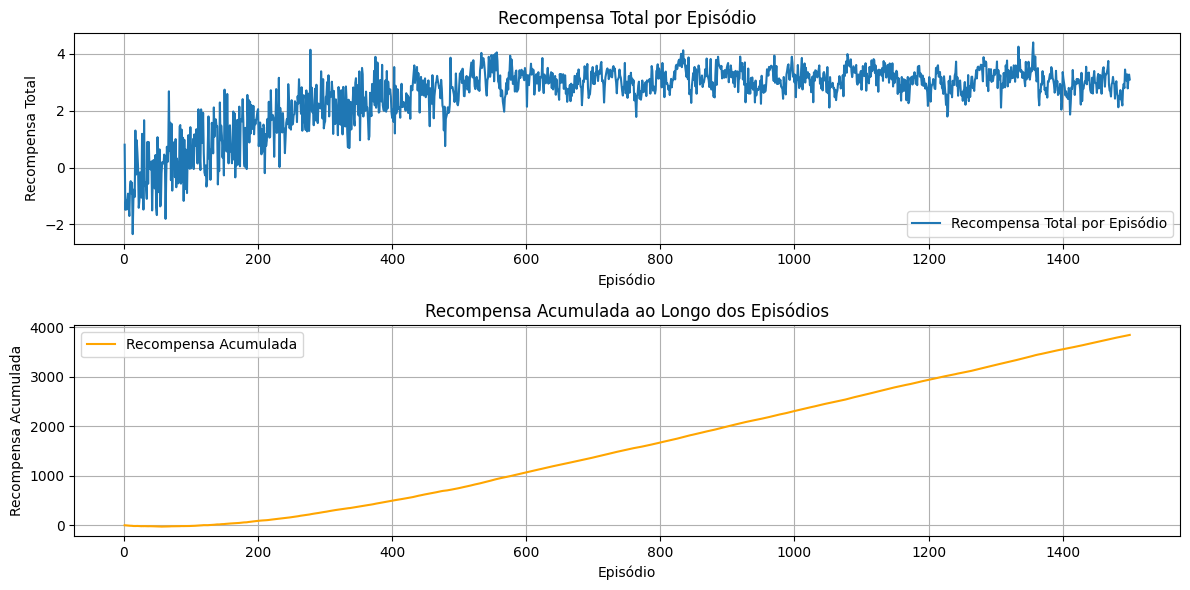

Análise de Desempenho:
- Recompensa Média por Episódio: 2.56
- Desvio Padrão da Recompensa: 1.08
- Recompensa Acumulada Total: 3845.13
- Máxima Recompensa em um Episódio: 4.40
- Mínima Recompensa em um Episódio: -2.35


In [18]:
plot_performance( rewards )

In [19]:
env_test = gym.make( "TradingEnv",
                name = "AAPL",
                positions = [-1, 0 , 1],
                df = data_test,
                dynamic_feature_functions = [],
                trading_fees = 0.01 / 100,
                borrow_interest_rate = 0.0003 / 100,
                # reward_function = reward_function
                )

def test_qlearning(env, q_table, q_map):
    """
    Testa a política de Q-learning no ambiente fornecido.

    Parâmetros:
    - env: O ambiente de teste.
    - q_table: A Q-table aprendida durante o treinamento.
    - q_map: Mapeamento de tuplas de estados para as linhas da Q-table.

    Retorna:
    - total_reward: A recompensa acumulada obtida durante o teste.
    """
    
    state, _ = env.reset()
    state = tuple( np.array( state ).flatten() )
    
    terminated = False
    truncated = False
    total_reward = 0

    while not ( terminated or truncated ):
        if state in q_map:
            state_row = q_map[state]
            action = np.argmax( q_table[state_row] )
        else:
            action = 0

        new_state, reward, terminated, truncated, info = env.step( action )
        new_state = tuple( np.array( new_state ).flatten() )
        total_reward += reward
        state = new_state

    print( f"Recompensa Total do Teste: {total_reward}" )
    return total_reward


In [20]:
total_reward = test_qlearning( env_test, q_table, q_map )

Market Return : 20.38%   |   Portfolio Return : 22.03%   |   
Recompensa Total do Teste: 0.19912679212333584


In [21]:
from gym_trading_env.renderer import Renderer

env_test.unwrapped.save_for_render( dir = "render_logs" )
renderer = Renderer( render_logs_dir="render_logs" )
renderer.run()

 * Serving Flask app 'gym_trading_env.renderer'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
